#Dataset

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d ayushmandatta1/deepdetect-2025

Dataset URL: https://www.kaggle.com/datasets/ayushmandatta1/deepdetect-2025
License(s): apache-2.0
100% 3.23G/3.23G [00:47<00:00, 22.4MB/s]
100% 3.23G/3.23G [00:47<00:00, 73.7MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/deepdetect-2025.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

##Removing Inconsistant Images

In [4]:
import os
from PIL import Image
import tensorflow as tf

def clean_directory(directory):
    cleaned_files_count = 0
    # Strictly enforce extensions required by TensorFlow's decode_image based on the error message
    required_image_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp')

    for root, _, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(root, file)
            file_size = os.path.getsize(filepath)

            # First, filter out zero-byte files as they are definitely problematic
            if file_size == 0:
                print(f"Removing zero-byte file: {filepath}")
                os.remove(filepath)
                cleaned_files_count += 1
                continue

            # Check if the file has one of the strictly required image extensions
            if filepath.lower().endswith(required_image_extensions):
                try:
                    # Try to open it with PIL first for a quick check
                    Image.open(filepath).close()

                    # Then, try to decode it with TensorFlow to catch more subtle issues
                    img_bytes = tf.io.read_file(filepath)
                    _ = tf.io.decode_image(img_bytes, channels=3, expand_animations=False)

                except Exception as e:
                    # If either PIL or TensorFlow decoding fails, it's corrupted or problematic
                    print(f"Removing corrupted/undecodable image file: {filepath} - Error: {e}")
                    os.remove(filepath)
                    cleaned_files_count += 1
            else:
                # If it doesn't have a required extension, remove it.
                # This covers cases like WEBP/TIFF/PDF/etc. that TF's decoder might not support by default.
                print(f"Removing file with unsupported extension: {filepath}")
                os.remove(filepath)
                cleaned_files_count += 1
    return cleaned_files_count

print("Cleaning train directory...")
cleaned_train_count = clean_directory('/content/ddata/train')
print(f"Removed {cleaned_train_count} problematic files from train directory.")

print("Cleaning test directory...")
cleaned_test_count = clean_directory('/content/ddata/test')
print(f"Removed {cleaned_test_count} problematic files from test directory.")

Cleaning train directory...
Removing corrupted/undecodable image file: /content/ddata/train/fake/fake_015223.jpg - Error: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Removing corrupted/undecodable image file: /content/ddata/train/fake/fake_040620.jpg - Error: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Removed 2 problematic files from train directory.
Cleaning test directory...
Removed 0 problematic files from test directory.


In [5]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Conv2D, GlobalAveragePooling2D, Flatten
from keras.models import Model

##Implementing Image Batches & Normalizing


In [6]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/ddata/train',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 128,
    color_mode = 'rgb',
    image_size = (240, 240)
)

test_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/ddata/test',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 64,
    color_mode = 'rgb',
    image_size = (240, 240)
)

Found 90407 files belonging to 2 classes.
Found 21776 files belonging to 2 classes.


In [7]:
from keras.applications.efficientnet import preprocess_input
def process(image, label):
    image = preprocess_input(image)
    return image,label

train_ds = train_ds.map(process)
test_ds = test_ds.map(process)

#Phase 1

In [8]:
from keras.applications import EfficientNetB1

In [9]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.30),
    keras.layers.RandomZoom(0.25),
    keras.layers.RandomContrast(0.3),
    keras.layers.RandomBrightness(0.3),
    keras.layers.RandomTranslation(0.1, 0.1),
])

In [10]:
# Stop training when validation loss doesn't improve
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

# Save best model based on validation accuracy
checkpoint = keras.callbacks.ModelCheckpoint(
    "best_sniffai_model.keras",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max",
    verbose=1
)

# Reduce LR when model stops improving (VERY important for finetuning)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=2,
    min_lr=1e-7,
    verbose=1
)

# Combine all callbacks into one list
callbacks_list = [early_stop, checkpoint, reduce_lr]

In [11]:
inputs = keras.Input(shape=(240,240,3))

x = data_augmentation(inputs)
x = preprocess_input(x)   # EfficientNet preprocessing

base_model = EfficientNetB1(include_top=False, weights='imagenet')
base_model.trainable = False    # IMPORTANT (Phase 1)

x = base_model(x, training=False)

x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

outputs = Dense(2, activation='softmax')(x)

model = keras.Model(inputs, outputs)

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
loss = keras.losses.SparseCategoricalCrossentropy()

In [13]:
model.compile(
    optimizer=keras.optimizers.Adam(9e-5),
    loss=loss,
    metrics=['accuracy']
)

In [14]:
history1 = model.fit(train_ds, epochs=5, validation_data=test_ds, callbacks=callbacks_list)

Epoch 1/5
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.6001 - loss: 0.8951
Epoch 1: val_accuracy improved from -inf to 0.69710, saving model to best_sniffai_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 395s 530ms/step - accuracy: 0.6002 - loss: 0.8950 - val_accuracy: 0.6971 - val_loss: 0.5889 - learning_rate: 9.0000e-05
Epoch 2/5
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.6727 - loss: 0.6705
Epoch 2: val_accuracy improved from 0.69710 to 0.72314, saving model to best_sniffai_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 374s 529ms/step - accuracy: 0.6727 - loss: 0.6705 - val_accuracy: 0.7231 - val_loss: 0.5475 - learning_rate: 9.0000e-05
Epoch 3/5
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.6956 - loss: 0.6090
Epoch 3: val_accuracy improved from 0.72314 to 0.73829, saving model to best_sniffai_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 374s 530ms/step - accuracy: 0.6956 - loss: 0.6090 - val_accuracy: 0.7383 - val_loss: 0.5264 - learning_rate: 9.0000e-05
Epoc

#2nd Phase

In [15]:
for layer in base_model.layers[-90:]:
    layer.trainable = True

In [16]:
model.compile(
    optimizer=keras.optimizers.Adam(9e-6),
    loss=loss,
    metrics=['accuracy']
)


In [17]:
history2 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=15,
    callbacks=callbacks_list
)

Epoch 1/15
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.6779 - loss: 0.6116
Epoch 1: val_accuracy improved from 0.75455 to 0.75794, saving model to best_sniffai_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 494s 663ms/step - accuracy: 0.6779 - loss: 0.6116 - val_accuracy: 0.7579 - val_loss: 0.4951 - learning_rate: 9.0000e-06
Epoch 2/15
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.7469 - loss: 0.5175
Epoch 2: val_accuracy improved from 0.75794 to 0.78361, saving model to best_sniffai_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 464s 656ms/step - accuracy: 0.7470 - loss: 0.5175 - val_accuracy: 0.7836 - val_loss: 0.4594 - learning_rate: 9.0000e-06
Epoch 3/15
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.7742 - loss: 0.4742
Epoch 3: val_accuracy improved from 0.78361 to 0.78596, saving model to best_sniffai_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 477s 674ms/step - accuracy: 0.7742 - loss: 0.4742 - val_accuracy: 0.7860 - val_loss: 0.4524 - learning_rate: 9.0000e-0

#Performance Visualization

to be continued ...

In [18]:
import matplotlib.pyplot as plt

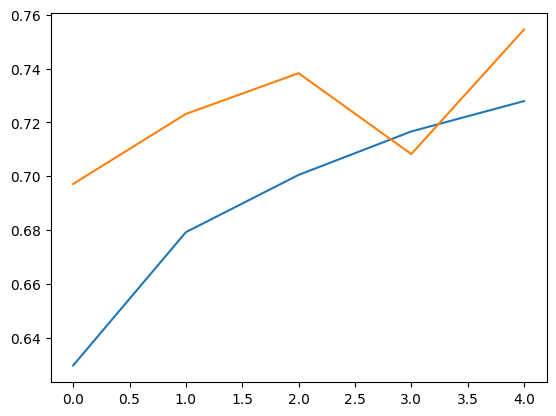

In [19]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])

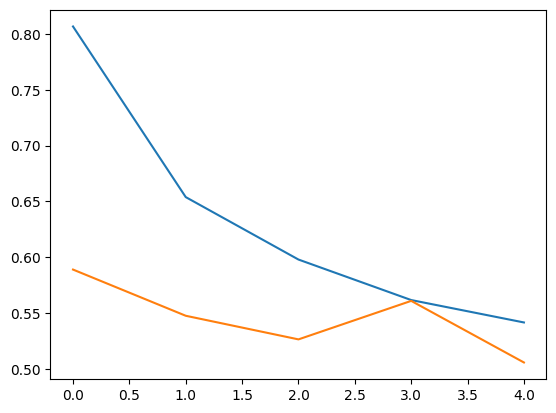

In [20]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])

#Saving the model for further Optimization

##.keras model

In [21]:
model.save("SniffAI_v1.keras")

##SavedModel

In [25]:
model.export("SniffAI_v1")

Saved artifact at 'SniffAI_v1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 240, 240, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  137038213372368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137038213380240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137038213381200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137038213381392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137038213376592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137038213381968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137036467759312: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  137036467760848: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  137038213381008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137037916787664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13

In [28]:
!zip -r SniffAI_v1.zip SniffAI_v1
from google.colab import files
files.download("SniffAI_v1.zip")

  adding: SniffAI_v1/ (stored 0%)
  adding: SniffAI_v1/saved_model.pb (deflated 91%)
  adding: SniffAI_v1/variables/ (stored 0%)
  adding: SniffAI_v1/variables/variables.index (deflated 77%)
  adding: SniffAI_v1/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: SniffAI_v1/assets/ (stored 0%)
  adding: SniffAI_v1/fingerprint.pb (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Model Structure

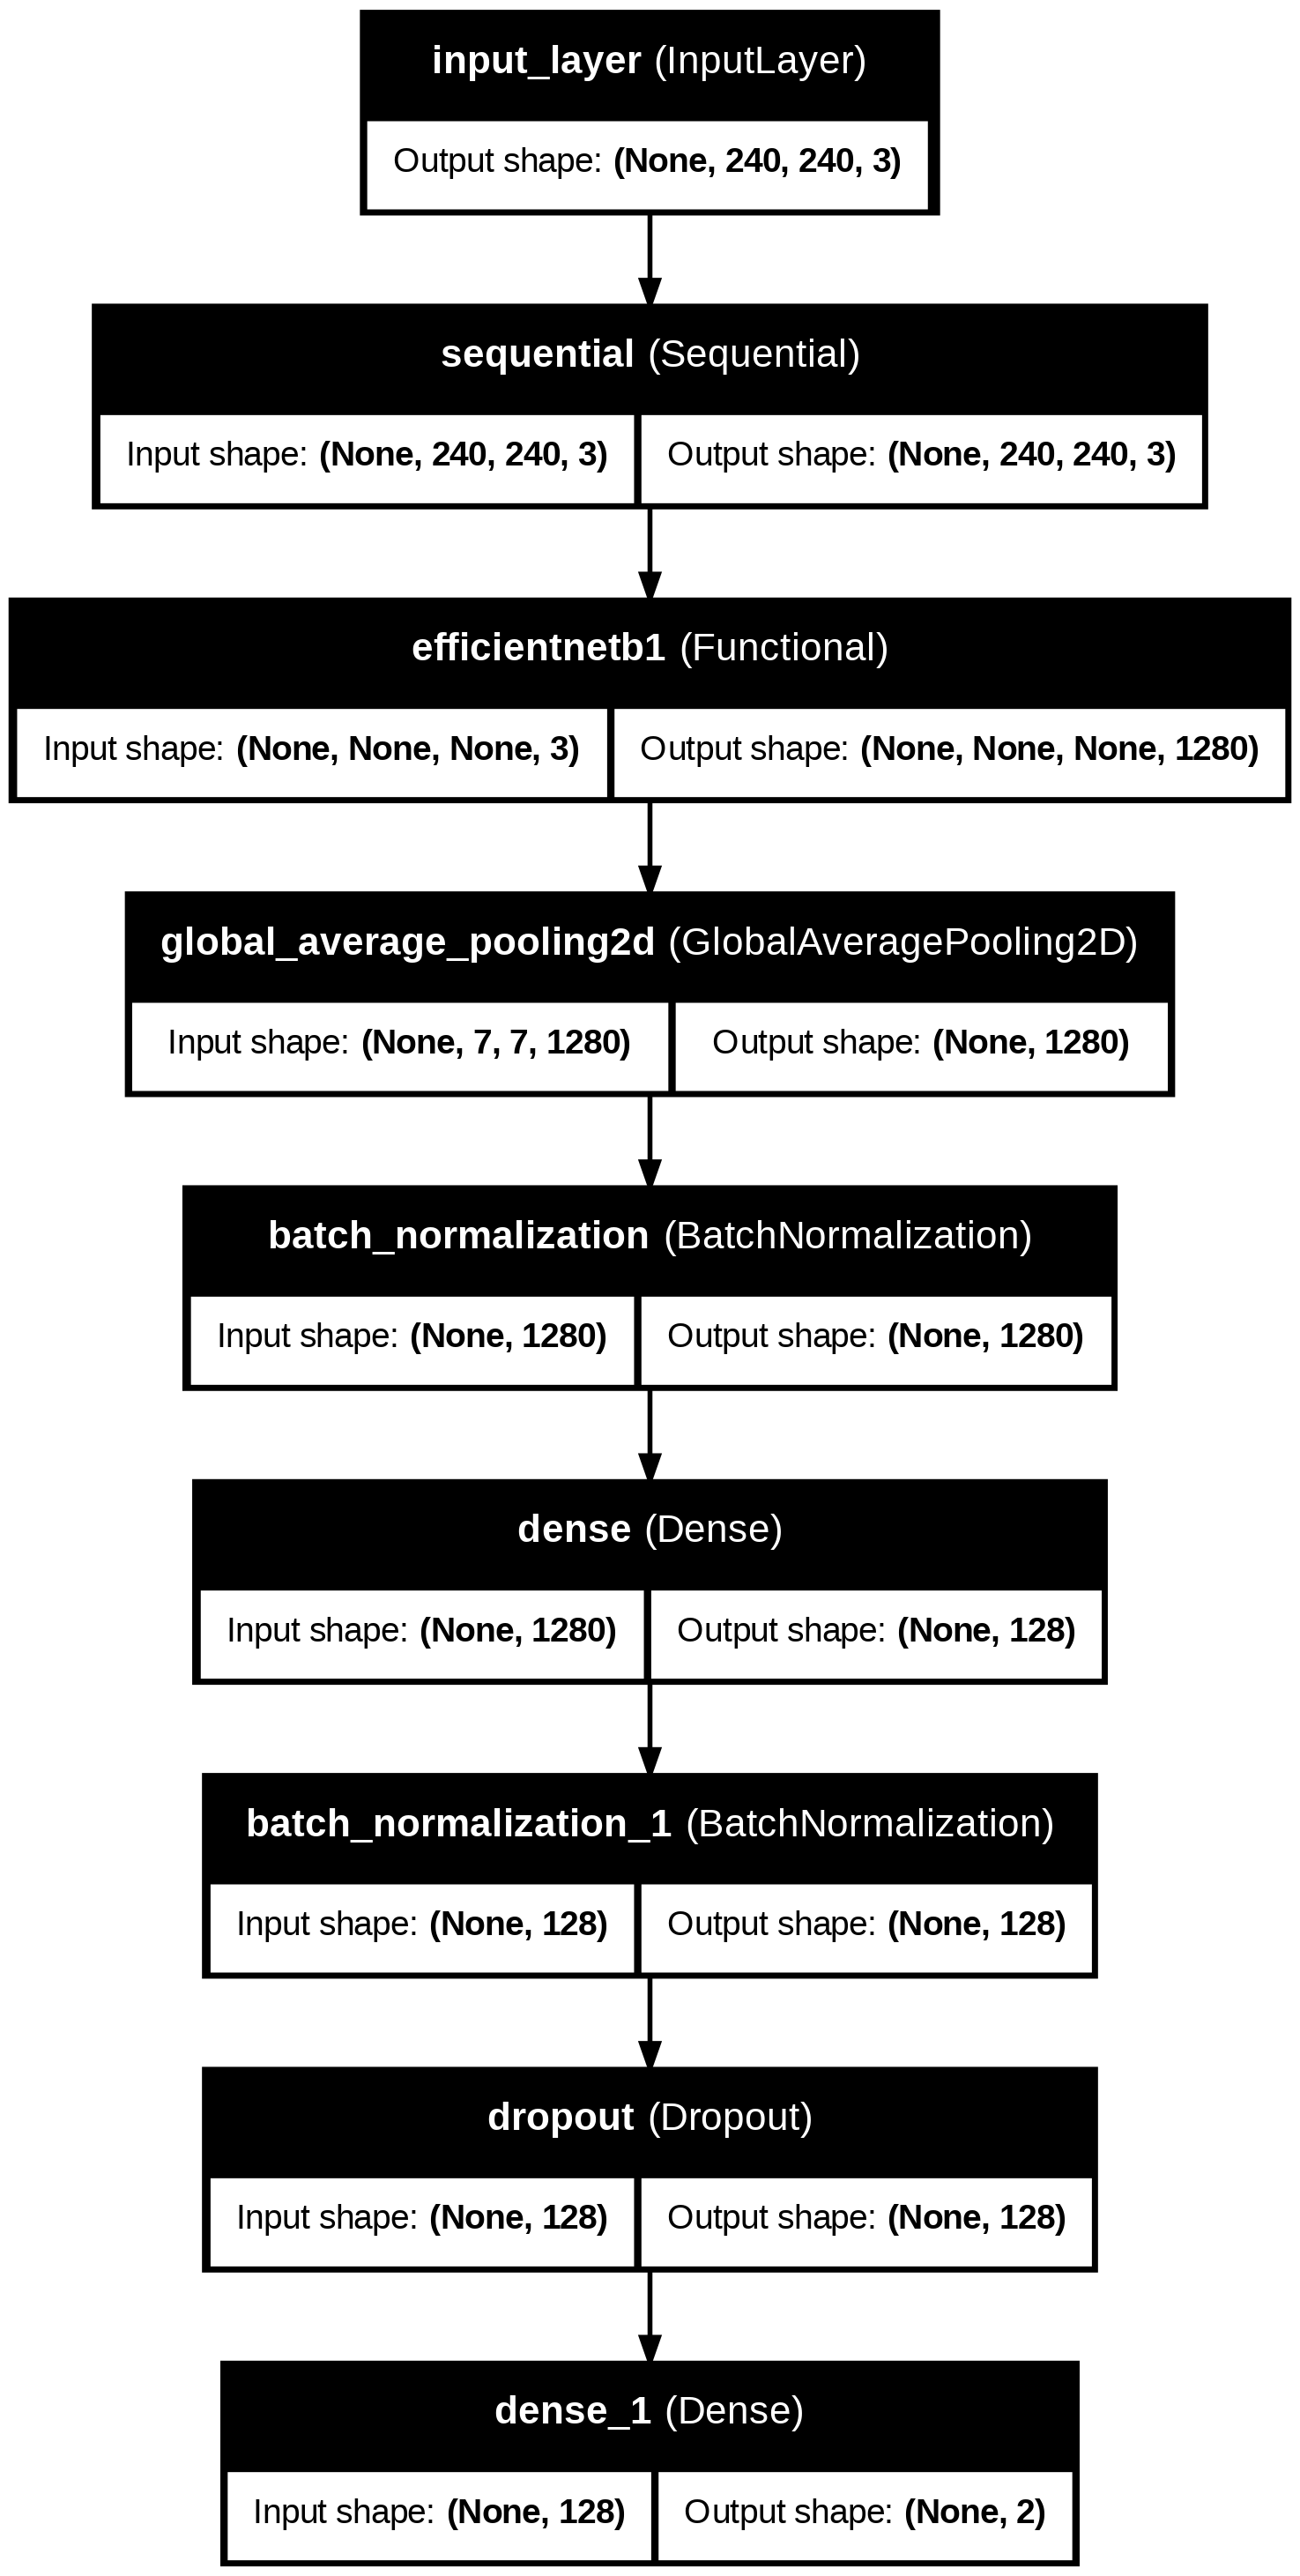

In [26]:
from keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)